In [1]:
# =============================================================================
# 1. IMPORTS & SETUP
# =============================================================================
import numpy as np
import pandas as pd
from IPython.core.display_functions import display

# Sklearn & related imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Other libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import make_scorer, balanced_accuracy_score

# Load data
df_weather2 = pd.read_csv('/Users/shayan/Desktop/IDS2/Stattkueche/df_weather3.csv', parse_dates=['DateOfCancel', 'DateOfService'])



In [2]:
# =============================================================================
# 2. CUSTOM TRANSFORMER DEFINITIONS
# =============================================================================

class InCVTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols, smoothing=1.0):
        self.cols = cols
        self.smoothing = smoothing

    def fit(self, X, y):
        self.global_mean_ = y.mean()
        self.mapping_ = {}
        for c in self.cols:
            df = pd.DataFrame({c: X[c], 'target': y})
            agg = df.groupby(c)['target'].agg(['mean', 'count'])
            # smoothing formula
            agg['enc'] = (
                (agg['count'] * agg['mean'] +
                 self.smoothing * self.global_mean_)
                / (agg['count'] + self.smoothing)
            )
            self.mapping_[c] = agg['enc']
        return self

    def transform(self, X):
        X = X.copy()
        for c in self.cols:
            X[c + '_te'] = X[c]\
                .map(self.mapping_.get(c))\
                .fillna(self.global_mean_)
        return X

class HistCancelRateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, group_keys=('Site','MenuBase'), value_col='net_qty', out_col='hist_cancel_rate'):
        self.group_keys = group_keys
        self.value_col  = value_col
        self.out_col    = out_col
    def fit(self, X, y=None):
        keys = list(self.group_keys)
        self.hist_    = X.groupby(keys)[self.value_col].mean()
        self.default_ = self.hist_.median()
        return self
    def transform(self, X):
        keys   = list(self.group_keys)
        tuples = [tuple(r) for r in X[keys].values]
        X      = X.copy()
        X[self.out_col] = [self.hist_.get(t, self.default_) for t in tuples]
        return X

class ClusterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, profile_feats, group_keys=('Site','MenuBase'),
                 n_clusters=5, out_col='cluster_id'):
        self.profile_feats = profile_feats
        self.group_keys    = group_keys
        self.n_clusters    = n_clusters
        self.out_col       = out_col
    def fit(self, X, y=None):
        keys = list(self.group_keys)
        prof = (X.groupby(keys)[self.profile_feats].mean().reset_index())
        prof[self.profile_feats] = prof[self.profile_feats].fillna(prof[self.profile_feats].median())
        self.scaler_ = StandardScaler().fit(prof[self.profile_feats])
        scaled      = self.scaler_.transform(prof[self.profile_feats])
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=10).fit(scaled) # Set n_init explicitly
        tuples      = [tuple(r) for r in prof[keys].values]
        self.cluster_map_ = dict(zip(tuples, self.kmeans_.labels_))
        self.default_     = int(np.median(self.kmeans_.labels_))
        return self
    def transform(self, X):
        X = X.copy()
        keys   = list(self.group_keys)
        tuples = [tuple(r) for r in X[keys].values]
        X[self.out_col] = [self.cluster_map_.get(t, self.default_) for t in tuples]
        return X

class MissingFlagImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='median'):
        self.strategy = strategy
    def fit(self, X, y=None):
        self.num_cols = X.select_dtypes(include=[np.number]).columns
        clean = X[self.num_cols].replace([np.inf,-np.inf], np.nan)
        self.imputer_ = SimpleImputer(strategy=self.strategy).fit(clean)
        return self
    def transform(self, X):
        X = X.copy()
        X[self.num_cols] = X[self.num_cols].replace([np.inf,-np.inf], np.nan)
        for c in self.num_cols:
            X[c + '_missing'] = X[c].isna().astype(int)
        X[self.num_cols] = self.imputer_.transform(X[self.num_cols])
        return X

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_drop):
        self.cols_to_drop = cols_to_drop
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(columns=self.cols_to_drop, errors='ignore')


In [3]:
# =============================================================================
# 3. VIF CHECK
# =============================================================================
num_cols = df_weather2.select_dtypes(include=[np.number]).columns.to_list()

drop_col = ['DateOfOrder', 'DateOfService','days_to_cancel','CanceledQty','OrderId', 'TransactionId','cancel_timing','BookingNr','DateOfCancel','net_qty']
vif_col_1 = [c for c in num_cols if c not in drop_col]

# FIX 1: Changed df_encoded to df_weather2
vif_dat_1 = df_weather2[vif_col_1].copy()
vif_dat_1.replace([np.inf,-np.inf],np.nan,inplace=True)
vif_dat_1 = vif_dat_1.dropna()

vif_scores_1 = [variance_inflation_factor(vif_dat_1.values, i) for i in range(vif_dat_1.shape[1])]

vif_table_1 = (pd.DataFrame({'feature':vif_col_1,'VIF':vif_scores_1}).sort_values('VIF',ascending=False).reset_index(drop=True))
print('VIF values')
display(vif_table_1)

hg_vif_1 = vif_table_1.loc[vif_table_1['VIF']>10,'feature'].to_list()
print('the high vif columns dropped')
df_without_vif_1 = vif_dat_1.drop(columns=hg_vif_1)
print(df_without_vif_1.columns)


/Users/shayan/Desktop/IDS2/Stattkueche/venv_arm/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF values


,feature,VIF
0,afternoon,inf
1,morning,inf
2,evening,inf
3,day_of_year,3.102898e+04
4,month,3.086469e+04
5,day_of_month,1.300759e+02
6,quarter,2.209046e+01
7,MenuSubsidy,6.593575e+00
8,MenuPrice,6.495096e+00
9,order_hour,5.359547e+00


the high vif columns dropped
Index(['Unnamed: 0', 'OrderQty', 'MenuPrice', 'MenuSubsidy', 'weekday',
       'is_weekend', 'sin_doy', 'cos_doy', 'is_month_end', 'is_month_start',
       'order_hour', 'hist_cancel_rate', 'is_holiday', 'tavg_C', 'prcp_mm',
       'rain_flag', 'temp_dev'],
      dtype='object')


In [7]:
# # =============================================================================
# # 4. STAGE A: RANDOM FOREST
# # =============================================================================
# df_A    = df_weather2.copy()
# y_A     = (df_A['CanceledQty'] > 0).astype(int)
# X_A     = df_A.drop(columns=[
#     'CanceledQty', 'cancel_timing', 'DateOfOrder', 'DateOfService', 'DateOfCancel',
#     'OrderId', 'TransactionId', 'BookingNr', 'hist_cancel_rate', 'GroupName', 'SchoolID'
# ])
#
# drop_cols_A = [
#     'Site','MenuBase','MenuName','GroupName','MenuNorm','MenuCode','net_qty','days_to_cancel'
# ]
#
# pipeline_A = ImbPipeline([
#     ('te',      InCVTargetEncoder(cols=['Site','MenuBase'], smoothing=0.3)), # FIX 2: This now works as the class is pre-defined
#     ('hist',    HistCancelRateTransformer()),
#     ('cluster', ClusterTransformer(
#                    profile_feats=['hist_cancel_rate','rain_flag','temp_dev','sin_doy', 'cos_doy', 'month',
#        'day_of_month', 'is_month_end', 'is_month_start','tavg_C', 'prcp_mm'],
#                    n_clusters=5)),
#     ('drop',    ColumnDropper(drop_cols_A)),
#     ('impute',  MissingFlagImputer()),
#     ('clf',     RandomForestClassifier(
#                    n_estimators=500, criterion='entropy', max_depth=8,
#                    min_samples_split=5, min_samples_leaf=1, max_features='sqrt',
#                    class_weight='balanced_subsample', random_state=24, n_jobs=-1
#                )),
# ])
#
# tscv    = TimeSeriesSplit(n_splits=5)
# scores  = cross_val_score(pipeline_A, X_A, y_A, cv=tscv, scoring='roc_auc', n_jobs=-1)
# print("Stage A ROC-AUC:", np.round(scores.mean(),4))
#


# =============================================================================
# 4. STAGE A: RANDOM FOREST (Faster Version ⚡)
# =============================================================================
df_A    = df_weather2.copy()
y_A     = (df_A['CanceledQty'] > 0).astype(int)
X_A     = df_A.drop(columns=[
    'CanceledQty', 'cancel_timing', 'DateOfOrder', 'DateOfService', 'DateOfCancel',
    'OrderId', 'TransactionId', 'BookingNr', 'hist_cancel_rate', 'GroupName', 'SchoolID'
])

# --- SPEEDUP 1: Use a smaller, 25% sample of the data for a quick check ---
print("Creating a 25% data sample to run faster...")
sample_indices = df_A.sample(frac=0.25, random_state=42).index
X_A_sample = X_A.loc[sample_indices].copy()
y_A_sample = y_A.loc[sample_indices].copy()


drop_cols_A = [
    'Site','MenuBase','MenuName','GroupName','MenuNorm','MenuCode','net_qty','days_to_cancel'
]

pipeline_A = ImbPipeline([
    ('te',      InCVTargetEncoder(cols=['Site','MenuBase'], smoothing=0.3)),
    ('hist',    HistCancelRateTransformer()),
    ('cluster', ClusterTransformer(
                   profile_feats=['hist_cancel_rate','rain_flag','temp_dev','sin_doy', 'cos_doy', 'month',
       'day_of_month', 'is_month_end', 'is_month_start','tavg_C', 'prcp_mm'],
                   n_clusters=5)),
    ('drop',    ColumnDropper(drop_cols_A)),
    ('impute',  MissingFlagImputer()),
    ('clf',     RandomForestClassifier(
                   # --- SPEEDUP 2: Drastically reduce the number of trees ---
                   n_estimators=50, # Reduced from 500
                   criterion='entropy',
                   max_depth=8,
                   min_samples_split=5,
                   min_samples_leaf=1,
                   max_features='sqrt',
                   class_weight='balanced_subsample',
                   random_state=24,
                   n_jobs=-1
               )),
])

# --- SPEEDUP 3: Reduce the number of cross-validation splits ---
tscv_fast = TimeSeriesSplit(n_splits=3) # Reduced from 5

print("Starting cross-validation on the smaller sample with fewer estimators...")
# Run on the sampled data with the faster settings
scores  = cross_val_score(pipeline_A, X_A_sample, y_A_sample, cv=tscv_fast, scoring='roc_auc', n_jobs=-1)

print("Stage A ROC-AUC (from fast run):", np.round(scores.mean(),4))

Creating a 25% data sample to run faster...
Starting cross-validation on the smaller sample with fewer estimators...
Stage A ROC-AUC (from fast run): 0.8529


In [9]:
# # =============================================================================
# # 5. STAGE B2: RF, LGBM, CATBOOST (FASTER VERSION ⚡)
# # =============================================================================
#
# # --- SPEEDUP 1: Use a fraction of the data for faster testing ---
# df_B2_sample = df_weather2[df_weather2.cancel_timing != 'no_cancel'].sample(frac=0.25, random_state=42)
#
# le = LabelEncoder().fit(df_B2_sample.cancel_timing)
# df_B2_sample['timing_code'] = le.transform(df_B2_sample.cancel_timing)
#
# X_B2 = df_B2_sample.drop(columns=['CanceledQty', 'cancel_timing','timing_code', 'DateOfOrder','DateOfService', 'DateOfCancel', 'OrderId','TransactionId','BookingNr','hist_cancel_rate', 'GroupName','SchoolID'])
# y_B2 = df_B2_sample['timing_code']
#
# drop_cols_B2 = ['MenuName','GroupName','MenuNorm','MenuCode']
# drop_post = ['Site','MenuBase','net_qty','days_to_cancel']
#
# # --- SPEEDUP 2: Reduce the number of cross-validation splits ---
# tscv = TimeSeriesSplit(n_splits=3)
#
# # --- Pipelines ---
# # Base steps for all pipelines
# base_steps = [
#     ('te', InCVTargetEncoder(cols=['Site','MenuBase'], smoothing=0.3)),
#     ('drop', ColumnDropper(drop_cols_B2)),
#     ('hist', HistCancelRateTransformer()),
#     ('cluster', ClusterTransformer(profile_feats=['hist_cancel_rate','rain_flag','temp_dev','sin_doy', 'cos_doy', 'month', 'day_of_month', 'is_month_end', 'is_month_start','tavg_C', 'prcp_mm'], n_clusters=5)),
#     ('drop_post', ColumnDropper(drop_post)),
#     ('impute', MissingFlagImputer()),
#     ('smote', SMOTE(random_state=24))
# ]
#
# # --- SPEEDUP 3: Reduce n_iter for each search ---
# N_ITER = 3 # Set the number of iterations for all searches
#
# # RF
# pipeline_B2_rf = ImbPipeline(base_steps + [('clf', RandomForestClassifier(class_weight='balanced', random_state=24, n_jobs=-1))])
# param_dist_rf = {'clf__n_estimators': [200, 500], 'clf__max_depth': [6, 10], 'clf__min_samples_split': [10, 20]}
# search_rf = RandomizedSearchCV(pipeline_B2_rf, param_distributions=param_dist_rf, n_iter=N_ITER, cv=tscv, scoring='roc_auc_ovo_weighted', n_jobs=-1, random_state=24)
# search_rf.fit(X_B2, y_B2)
# print(f"Best Stage B2 RF roc_auc_ovo_weighted: {search_rf.best_score_:.4f}")
#
# # LGBM
# pipeline_B2_lgbm = ImbPipeline(base_steps + [('clf', LGBMClassifier(objective='multiclass', num_class=len(le.classes_), random_state=24, metric="multi_logloss", n_jobs=-1))])
# param_dist_lgbm_b2 = {'clf__n_estimators': [200, 500], 'clf__learning_rate': [0.01, 0.07], 'clf__num_leaves': [31, 40]}
# search_lgbm = RandomizedSearchCV(pipeline_B2_lgbm, param_distributions=param_dist_lgbm_b2, n_iter=N_ITER, cv=tscv, scoring='roc_auc_ovo_weighted', n_jobs=-1, random_state=24)
# search_lgbm.fit(X_B2, y_B2)
# print(f"Best Stage B2 LGBM ROC_AUC_OVO_weighted: {search_lgbm.best_score_:.4f}")
#
# # CatBoost
# pipeline_B2_cat = ImbPipeline(base_steps + [('clf', CatBoostClassifier(auto_class_weights='Balanced', loss_function='MultiClass', early_stopping_rounds=50, verbose=False, random_seed=24, thread_count=-1))])
# cat_param_dist = {'clf__iterations': [200, 500], 'clf__learning_rate': [0.03, 0.1], 'clf__depth': [6, 8]}
# scoring_1 = {'roc_auc_ovo': 'roc_auc_ovo'}
# search_cat = RandomizedSearchCV(pipeline_B2_cat, param_distributions=cat_param_dist, n_iter=N_ITER, cv=tscv, refit='roc_auc_ovo', scoring=scoring_1, n_jobs=-1, random_state=24)
# search_cat.fit(X_B2, y_B2)
# print(f"Best Stage B2 CatBoost Score (roc_auc_ovo): {search_cat.best_score_:.4f}")


# Add this import to the top of your script (Block 1)
import re

# Add this class to your custom transformer definitions (Block 2)
class FeatureNameSanitizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        df = X.copy()
        df.columns = [re.sub(r'[^A-Za-z0-9_]+', '', str(col)) for col in df.columns]
        return df

# =============================================================================
# 5. STAGE B2: RF, LGBM, CATBOOST (FIXED VERSION ✅)
# =============================================================================

# --- SPEEDUP 1: Use a fraction of the data for faster testing ---
df_B2_sample = df_weather2[df_weather2.cancel_timing != 'no_cancel'].sample(frac=0.25, random_state=42)

le = LabelEncoder().fit(df_B2_sample.cancel_timing)
df_B2_sample['timing_code'] = le.transform(df_B2_sample.cancel_timing)

X_B2 = df_B2_sample.drop(columns=['CanceledQty', 'cancel_timing','timing_code', 'DateOfOrder','DateOfService', 'DateOfCancel', 'OrderId','TransactionId','BookingNr','hist_cancel_rate', 'GroupName','SchoolID'])
y_B2 = df_B2_sample['timing_code']

drop_cols_B2 = ['MenuName','GroupName','MenuNorm','MenuCode']
drop_post = ['Site','MenuBase','net_qty','days_to_cancel']

# --- SPEEDUP 2: Reduce the number of cross-validation splits ---
tscv = TimeSeriesSplit(n_splits=3)

# --- Pipelines ---
# Base steps for all pipelines
base_steps = [
    ('te', InCVTargetEncoder(cols=['Site','MenuBase'], smoothing=0.3)),
    ('drop', ColumnDropper(drop_cols_B2)),
    ('hist', HistCancelRateTransformer()),
    ('cluster', ClusterTransformer(profile_feats=['hist_cancel_rate','rain_flag','temp_dev','sin_doy', 'cos_doy', 'month', 'day_of_month', 'is_month_end', 'is_month_start','tavg_C', 'prcp_mm'], n_clusters=5)),
    ('drop_post', ColumnDropper(drop_post)),
    ('impute', MissingFlagImputer()),
    ('sanitize', FeatureNameSanitizer()), # <--- FIX: Added step to clean column names
    ('smote', SMOTE(random_state=24))
]

# --- SPEEDUP 3: Reduce n_iter for each search ---
N_ITER = 3 # Set the number of iterations for all searches

# RF
pipeline_B2_rf = ImbPipeline(base_steps + [('clf', RandomForestClassifier(class_weight='balanced', random_state=24, n_jobs=-1))])
param_dist_rf = {'clf__n_estimators': [200, 500], 'clf__max_depth': [6, 10], 'clf__min_samples_split': [10, 20]}
search_rf = RandomizedSearchCV(pipeline_B2_rf, param_distributions=param_dist_rf, n_iter=N_ITER, cv=tscv, scoring='roc_auc_ovo_weighted', n_jobs=-1, random_state=24)
search_rf.fit(X_B2, y_B2)
print(f"Best Stage B2 RF roc_auc_ovo_weighted: {search_rf.best_score_:.4f}")

# LGBM
pipeline_B2_lgbm = ImbPipeline(base_steps + [('clf', LGBMClassifier(objective='multiclass', num_class=len(le.classes_), random_state=24, metric="multi_logloss", n_jobs=-1))])
param_dist_lgbm_b2 = {'clf__n_estimators': [200, 500], 'clf__learning_rate': [0.01, 0.07], 'clf__num_leaves': [31, 40]}
search_lgbm = RandomizedSearchCV(pipeline_B2_lgbm, param_distributions=param_dist_lgbm_b2, n_iter=N_ITER, cv=tscv, scoring='roc_auc_ovo_weighted', n_jobs=-1, random_state=24)
search_lgbm.fit(X_B2, y_B2)
print(f"Best Stage B2 LGBM ROC_AUC_OVO_weighted: {search_lgbm.best_score_:.4f}")

# CatBoost
pipeline_B2_cat = ImbPipeline(base_steps + [('clf', CatBoostClassifier(auto_class_weights='Balanced', loss_function='MultiClass', early_stopping_rounds=50, verbose=False, random_seed=24, thread_count=-1))])
cat_param_dist = {'clf__iterations': [200, 500], 'clf__learning_rate': [0.03, 0.1], 'clf__depth': [6, 8]}
scoring_1 = {'roc_auc_ovo': 'roc_auc_ovo'}
search_cat = RandomizedSearchCV(pipeline_B2_cat, param_distributions=cat_param_dist, n_iter=N_ITER, cv=tscv, refit='roc_auc_ovo', scoring=scoring_1, n_jobs=-1, random_state=24)
search_cat.fit(X_B2, y_B2)
print(f"Best Stage B2 CatBoost Score (roc_auc_ovo): {search_cat.best_score_:.4f}")

Best Stage B2 RF roc_auc_ovo_weighted: 0.9119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5153
[LightGBM] [Info] Number of data points in the train set: 7281, number of used features: 24
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [11]:
# =============================================================================
# 6. STAGE B2: RANDOM FOREST (FASTER VERSION ⚡)
# =============================================================================
df_B2 = df_weather2[df_weather2.cancel_timing != 'no_cancel'].copy()
le    = LabelEncoder().fit(df_B2.cancel_timing)
df_B2['timing_code'] = le.transform(df_B2.cancel_timing)

# --- SPEEDUP 1: Use a smaller data sample (e.g., 25%) ---
print("Creating a 25% data sample to run faster...")
df_B2_sample = df_B2.sample(frac=0.25, random_state=42)
X_B2 = df_B2_sample.drop(columns=[
    'CanceledQty', 'cancel_timing','timing_code', 'DateOfOrder','DateOfService',
    'DateOfCancel', 'OrderId','TransactionId','BookingNr','hist_cancel_rate',
    'GroupName','SchoolID'
])
y_B2 = df_B2_sample['timing_code']


drop_cols_B2 = ['MenuName','GroupName','MenuNorm','MenuCode']
drop_post = ['Site','MenuBase','net_qty','days_to_cancel']

pipeline_B2_smote = ImbPipeline([
    ('te',      InCVTargetEncoder(cols=['Site','MenuBase'], smoothing=0.3)),
    ('drop',    ColumnDropper(drop_cols_B2)),
    ('hist',    HistCancelRateTransformer()),
    ('cluster', ClusterTransformer(
                    profile_feats=['hist_cancel_rate','rain_flag','temp_dev','sin_doy', 'cos_doy', 'month',
       'day_of_month', 'is_month_end', 'is_month_start','tavg_C', 'prcp_mm'],
                    n_clusters=5)),
    ('drop_post', ColumnDropper(drop_post)),
    ('impute',  MissingFlagImputer()),
    ('smote',   SMOTE(random_state=24)),
    ('clf',     RandomForestClassifier(
                   class_weight='balanced', random_state=24, n_jobs=-1
               )),
])

# --- SPEEDUP 2: Simplify the parameter grid, especially n_estimators ---
param_dist_rf_fast = {
    'clf__n_estimators':      [100, 200], # Drastically reduced from [600, 1200]
    'clf__max_depth':         [6, 10],
    'clf__min_samples_split': [10, 20],
    'clf__max_features':      ['sqrt'],   # Using just one option is faster
}

# --- SPEEDUP 3: Reduce CV splits and search iterations ---
tscv_fast = TimeSeriesSplit(n_splits=3) # Reduced from 5
N_ITER_FAST = 4                         # Reduced from 20

search_rf = RandomizedSearchCV(
    pipeline_B2_smote,
    param_distributions=param_dist_rf_fast,
    n_iter=N_ITER_FAST,
    cv=tscv_fast,
    scoring='roc_auc_ovo_weighted',
    n_jobs=-1,
    random_state=24
)

print("Starting Random Forest hyperparameter search with cheaper settings...")
search_rf.fit(X_B2, y_B2)

print("Best RF roc_auc_ovo_weighted (from fast run):", np.round(search_rf.best_score_, 4))
print("Best hyper-parameters:")
for k, v in search_rf.best_params_.items():
    print(f"  {k} = {v}")

Creating a 25% data sample to run faster...
Starting Random Forest hyperparameter search with cheaper settings...
Best RF roc_auc_ovo_weighted (from fast run): 0.9127
Best hyper-parameters:
  clf__n_estimators = 100
  clf__min_samples_split = 10
  clf__max_features = sqrt
  clf__max_depth = 10


In [15]:
# =============================================================================
# 7. STAGE B2: LGBM (FIXED & FASTER VERSION ✅)
# =============================================================================
# This assumes X_B2 and y_B2 are already defined as a data sample.

# Re-define the pipeline to include the sanitizer
pipeline_B2_lgbm = ImbPipeline([
    ('te',      InCVTargetEncoder(cols=['Site','MenuBase'], smoothing=0.3)),
    ('drop',    ColumnDropper(drop_cols_B2)),
    ('hist',    HistCancelRateTransformer()),
    ('cluster', ClusterTransformer(
                    profile_feats=['hist_cancel_rate','rain_flag','temp_dev','sin_doy', 'cos_doy', 'month',
       'day_of_month', 'is_month_end', 'is_month_start','tavg_C', 'prcp_mm'],
                    n_clusters=5)),
    ('drop_post', ColumnDropper(drop_post)),
    ('impute',  MissingFlagImputer()),
    ('sanitize', FeatureNameSanitizer()), # <--- FIX: Added step to clean column names
   ('clf',       LGBMClassifier(objective='multiclass',
                                 num_class=len(np.unique(y_B2)),
                                 random_state=24,
                                 metric="multi_logloss",
                                 n_jobs=-1))
])

# Use faster settings for the search
param_dist_lgbm_fast = {
    'clf__n_estimators':      [100, 300],
    'clf__learning_rate':     [0.05, 0.1],
    'clf__num_leaves':        [20, 31],
}
tscv_fast = TimeSeriesSplit(n_splits=3)
N_ITER_FAST = 5

search_lgbm_b2 = RandomizedSearchCV(
    pipeline_B2_lgbm,
    param_distributions=param_dist_lgbm_fast,
    n_iter=N_ITER_FAST,
    cv=tscv_fast,
    scoring='roc_auc_ovo_weighted',
    n_jobs=-1,
    random_state=24
)

print("Starting LGBM hyperparameter search with fixed pipeline...")
search_lgbm_b2.fit(X_B2, y_B2)

print("Best LGBM ROC_AUC_OVO_weighted (from fast run):", np.round(search_lgbm_b2.best_score_,4))
print("Best hyper‐parameters:")
for k, v in search_lgbm_b2.best_params_.items():
    print(f"  {k}: {v}")

Starting LGBM hyperparameter search with fixed pipeline...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1521
[LightGBM] [Info] Number of data points in the train set: 10988, number of used features: 23
[LightGBM] [Info] Start training from score -2.256173
[LightGBM] [Info] Start training from score -4.437025
[LightGBM] [Info] Start training from score -0.123956
Best LGBM ROC_AUC_OVO_weighted (from fast run): 0.9318
Best hyper‐parameters:
  clf__num_leaves: 31
  clf__n_estimators: 100
  clf__learning_rate: 0.05


In [16]:
# =============================================================================
# 8. STAGE B2: CATBOOST (FASTER VERSION ⚡)
# =============================================================================
# NOTE: This assumes X_B2 and y_B2 are already defined as a data sample.
# If not, the code will create a new sample.
if 'df_B2_sample' not in locals() and 'X_A_sample' not in locals():
    print("Creating a 25% data sample to run faster...")
    df_B2_sample = df_weather2[df_weather2.cancel_timing != 'no_cancel'].sample(frac=0.25, random_state=42)
    le = LabelEncoder().fit(df_B2_sample.cancel_timing)
    df_B2_sample['timing_code'] = le.transform(df_B2_sample.cancel_timing)
    X_B2 = df_B2_sample.drop(columns=[
        'CanceledQty', 'cancel_timing','timing_code', 'DateOfOrder','DateOfService',
        'DateOfCancel', 'OrderId','TransactionId','BookingNr','hist_cancel_rate',
        'GroupName','SchoolID'
    ])
    y_B2 = df_B2_sample['timing_code']


# It's good practice to include the sanitizer here too
pipeline_B2_cat = ImbPipeline([
    ('te',      InCVTargetEncoder(cols=['Site','MenuBase'], smoothing=0.3)),
    ('drop',    ColumnDropper(drop_cols_B2)),
    ('hist',    HistCancelRateTransformer()),
    ('cluster', ClusterTransformer(
                    profile_feats=['hist_cancel_rate','rain_flag','temp_dev','sin_doy', 'cos_doy', 'month',
       'day_of_month', 'is_month_end', 'is_month_start','tavg_C', 'prcp_mm'],
                    n_clusters=5)),
    ('drop_post', ColumnDropper(drop_post)),
    ('impute',  MissingFlagImputer()),
    ('sanitize', FeatureNameSanitizer()), # Added sanitizer for safety
    ('clf',     CatBoostClassifier(
                    auto_class_weights='Balanced',
                    loss_function='MultiClass',
                    early_stopping_rounds=25, # Shorter patience for faster runs
                    verbose=False,
                    random_seed=24,
                    thread_count=-1
               ))
])

# --- SPEEDUP 1: Simplify the parameter grid ---
cat_param_dist_fast = {
    'clf__iterations':       [200, 400], # Reduced from [500, 800, 1000]
    'clf__learning_rate':    [0.05, 0.1],
    'clf__depth':            [6, 8],
    'clf__l2_leaf_reg':      [3, 10],
}

# --- SPEEDUP 2: Simplify the scoring ---
# For a quick run, we only need the metric used for refit
scoring_fast = 'roc_auc_ovo'

# --- SPEEDUP 3: Reduce CV splits and search iterations ---
tscv_fast = TimeSeriesSplit(n_splits=3) # Reduced from 5
N_ITER_FAST = 4                         # Reduced from 30

search_cat = RandomizedSearchCV(
    pipeline_B2_cat,
    param_distributions=cat_param_dist_fast,
    n_iter=N_ITER_FAST,
    cv=tscv_fast,
    refit='roc_auc_ovo',
    scoring=scoring_fast,
    n_jobs=-1,
    random_state=24
)

print("Starting CatBoost hyperparameter search with cheaper settings...")
search_cat.fit(X_B2, y_B2)

print("Best CatBoost Score (refit='roc_auc_ovo'):", np.round(search_cat.best_score_,4))
print("Best hyper‐parameters:")
for k, v in search_cat.best_params_.items():
    print(f"  {k}: {v}")

Starting CatBoost hyperparameter search with cheaper settings...
Best CatBoost Score (refit='roc_auc_ovo'): 0.9237
Best hyper‐parameters:
  clf__learning_rate: 0.1
  clf__l2_leaf_reg: 3
  clf__iterations: 400
  clf__depth: 8


Loading data for EDA...
Successfully loaded df_weather3.csv.

Generating Chart 1: Target Variable Distribution...


/var/folders/_4/yzd4h3k95051tj7kpg425rk80000gn/T/ipykernel_78113/1546389489.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_A, palette='pastel')


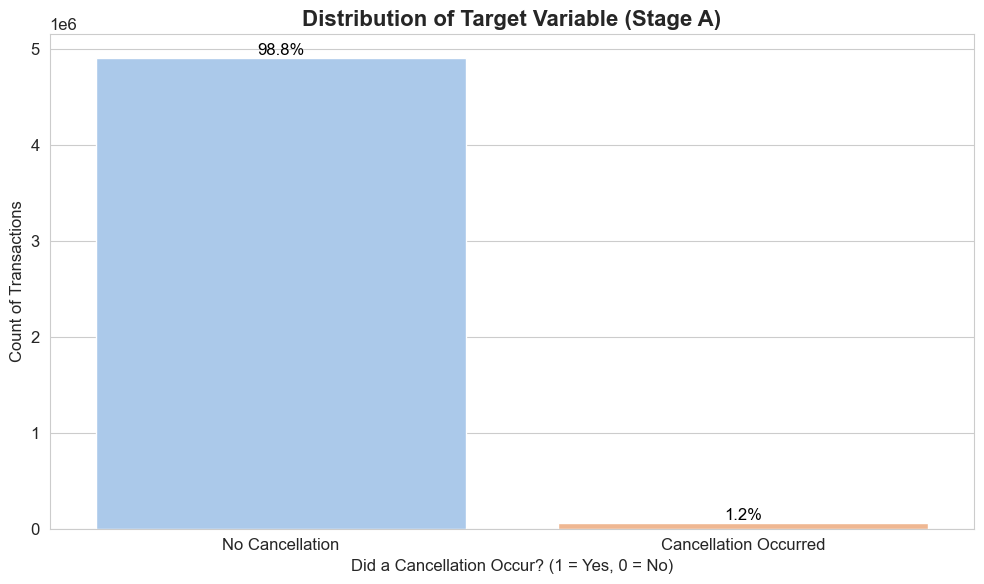


Generating Chart 2: Cancellation Timing Distribution...


/var/folders/_4/yzd4h3k95051tj7kpg425rk80000gn/T/ipykernel_78113/1546389489.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='cancel_timing', data=df_cancelled, order=df_cancelled['cancel_timing'].value_counts().index, palette='viridis')


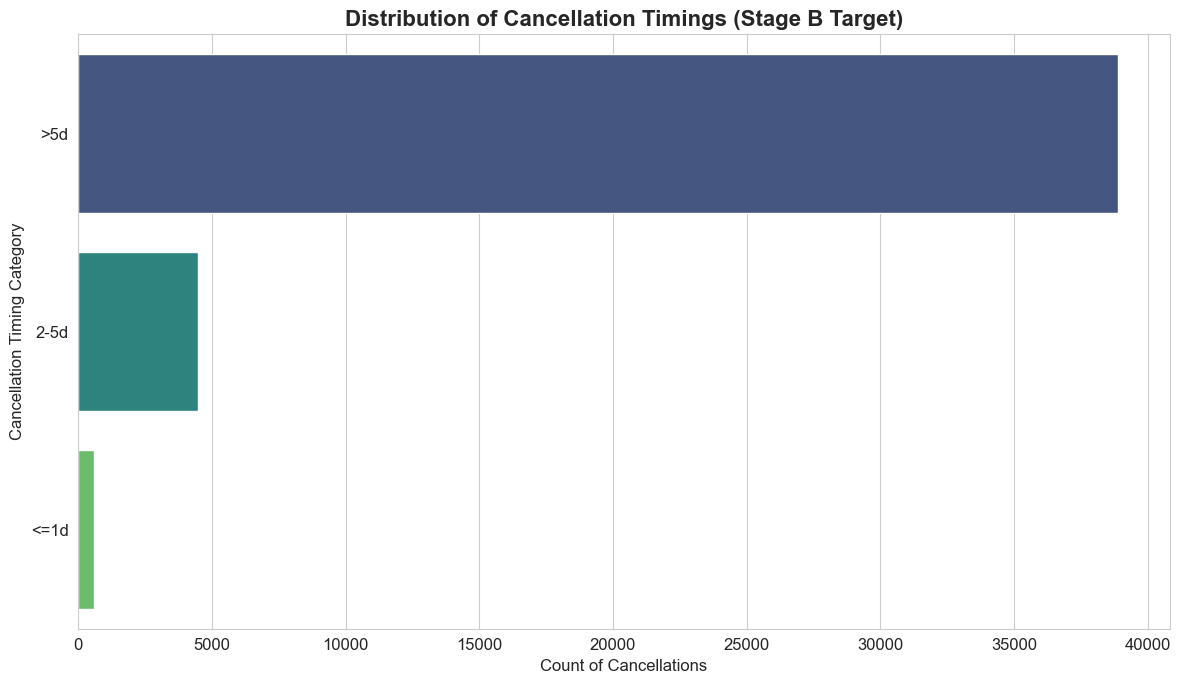


Generating Chart 3: Cancellation Rate by Site and MenuBase...


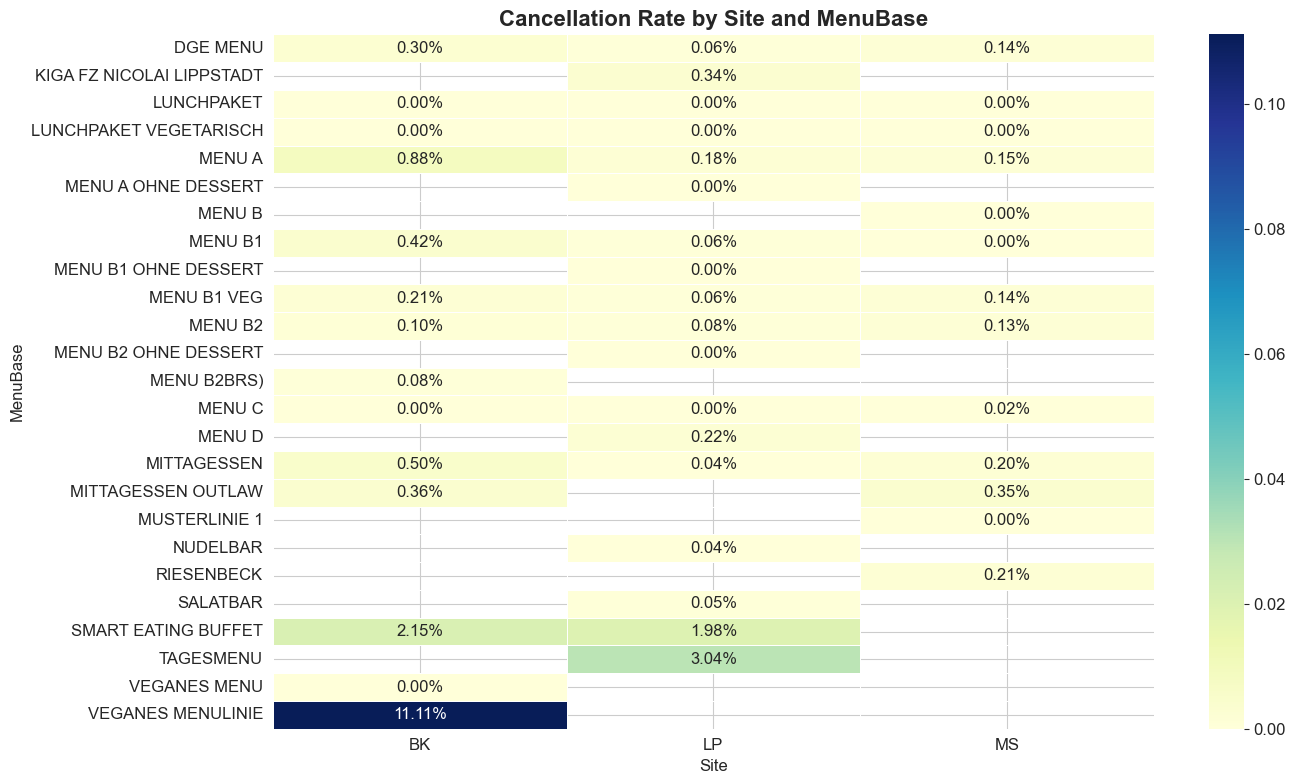


EDA script for classification finished. All charts have been generated and saved.


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =============================================================================
# --- Configuration ---
# =============================================================================
# Set a consistent plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 8)
plt.rcParams['figure.dpi'] = 100

# =============================================================================
# --- Data Loading ---
# =============================================================================
print("Loading data for EDA...")
try:
    # IMPORTANT: Update this path to your local file location
    df = pd.read_csv('/Users/shayan/Desktop/IDS2/Stattkueche/df_weather3.csv', parse_dates=['DateOfService', 'DateOfCancel'])
    print("Successfully loaded df_weather3.csv.")
except FileNotFoundError:
    print("FATAL ERROR: df_weather3.csv not found. Please update the file path.")
    # Create a dummy dataframe if the file is not found for demonstration
    dates = pd.to_datetime(pd.date_range(start='2022-01-01', end='2023-12-31', freq='D'))
    sites = ['siteMS', 'LP', 'BK']
    cancel_timings = ['no_cancel', 'last_minute', 'same_day', 'early']
    dummy_data = []
    for date in dates:
        for site in sites:
            dummy_data.append({
                'DateOfService': date,
                'DateOfCancel': date - pd.Timedelta(days=np.random.randint(1, 10)),
                'Site': site,
                'MenuBase': f'Menu_{np.random.randint(1,5)}',
                'CanceledQty': max(0, np.random.randint(-5, 10)),
                'net_qty': np.random.randint(40, 180),
                'tavg_C': np.random.uniform(5, 25),
                'prcp_mm': np.random.uniform(0, 10),
                'cancel_timing': np.random.choice(cancel_timings, p=[0.7, 0.1, 0.1, 0.1])
            })
    df = pd.DataFrame(dummy_data)


# =============================================================================
# --- Chart 1: Target Variable Distribution (Cancellation vs. No Cancellation) ---
# =============================================================================
print("\nGenerating Chart 1: Target Variable Distribution...")
plt.figure(figsize=(10, 6))
y_A = (df['CanceledQty'] > 0).astype(int)
sns.countplot(x=y_A, palette='pastel')
plt.title('Distribution of Target Variable (Stage A)', fontsize=16, weight='bold')
plt.xlabel('Did a Cancellation Occur? (1 = Yes, 0 = No)', fontsize=12)
plt.ylabel('Count of Transactions', fontsize=12)
plt.xticks([0, 1], ['No Cancellation', 'Cancellation Occurred'])
# Adding percentage labels
total = len(y_A)
for p in plt.gca().patches:
    percentage = f'{(p.get_height()/total)*100:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    plt.gca().annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12, color='black')
plt.tight_layout()
plt.savefig('EDA_Target_Distribution_Stage_A.png')
plt.show()


# =============================================================================
# --- Chart 2: Distribution of Cancellation Timings (Stage B) ---
# =============================================================================
print("\nGenerating Chart 2: Cancellation Timing Distribution...")
plt.figure(figsize=(12, 7))
# Filter for actual cancellations
df_cancelled = df[df['cancel_timing'] != 'no_cancel'].copy()
sns.countplot(y='cancel_timing', data=df_cancelled, order=df_cancelled['cancel_timing'].value_counts().index, palette='viridis')
plt.title('Distribution of Cancellation Timings (Stage B Target)', fontsize=16, weight='bold')
plt.xlabel('Count of Cancellations', fontsize=12)
plt.ylabel('Cancellation Timing Category', fontsize=12)
plt.tight_layout()
plt.savefig('EDA_Target_Distribution_Stage_B.png')
plt.show()


# =============================================================================
# --- Chart 3: Cancellation Rate by Site and MenuBase ---
# =============================================================================
print("\nGenerating Chart 3: Cancellation Rate by Site and MenuBase...")
df['cancelled'] = (df['CanceledQty'] > 0).astype(int)
cancellation_rates = df.groupby(['Site', 'MenuBase'])['cancelled'].mean().reset_index()
cancellation_rates = cancellation_rates.rename(columns={'cancelled': 'cancellation_rate'})

# Pivot for heatmap visualization
pivot_table = cancellation_rates.pivot(index='MenuBase', columns='Site', values='cancellation_rate')

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, annot=True, fmt=".2%", cmap='YlGnBu', linewidths=.5)
plt.title('Cancellation Rate by Site and MenuBase', fontsize=16, weight='bold')
plt.xlabel('Site', fontsize=12)
plt.ylabel('MenuBase', fontsize=12)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('EDA_Cancellation_Rate_Heatmap.png')
plt.show()

print("\nEDA script for classification finished. All charts have been generated and saved.")

Loading data and calculating VIF scores...
Calculating VIF scores. This may take a moment...


/Users/shayan/Desktop/IDS2/Stattkueche/venv_arm/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF calculation complete.

Generating Chart 4: VIF Score Visualization...


/Users/shayan/Desktop/IDS2/Stattkueche/venv_arm/lib/python3.13/site-packages/matplotlib/transforms.py:351: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 0] - points[0, 0]


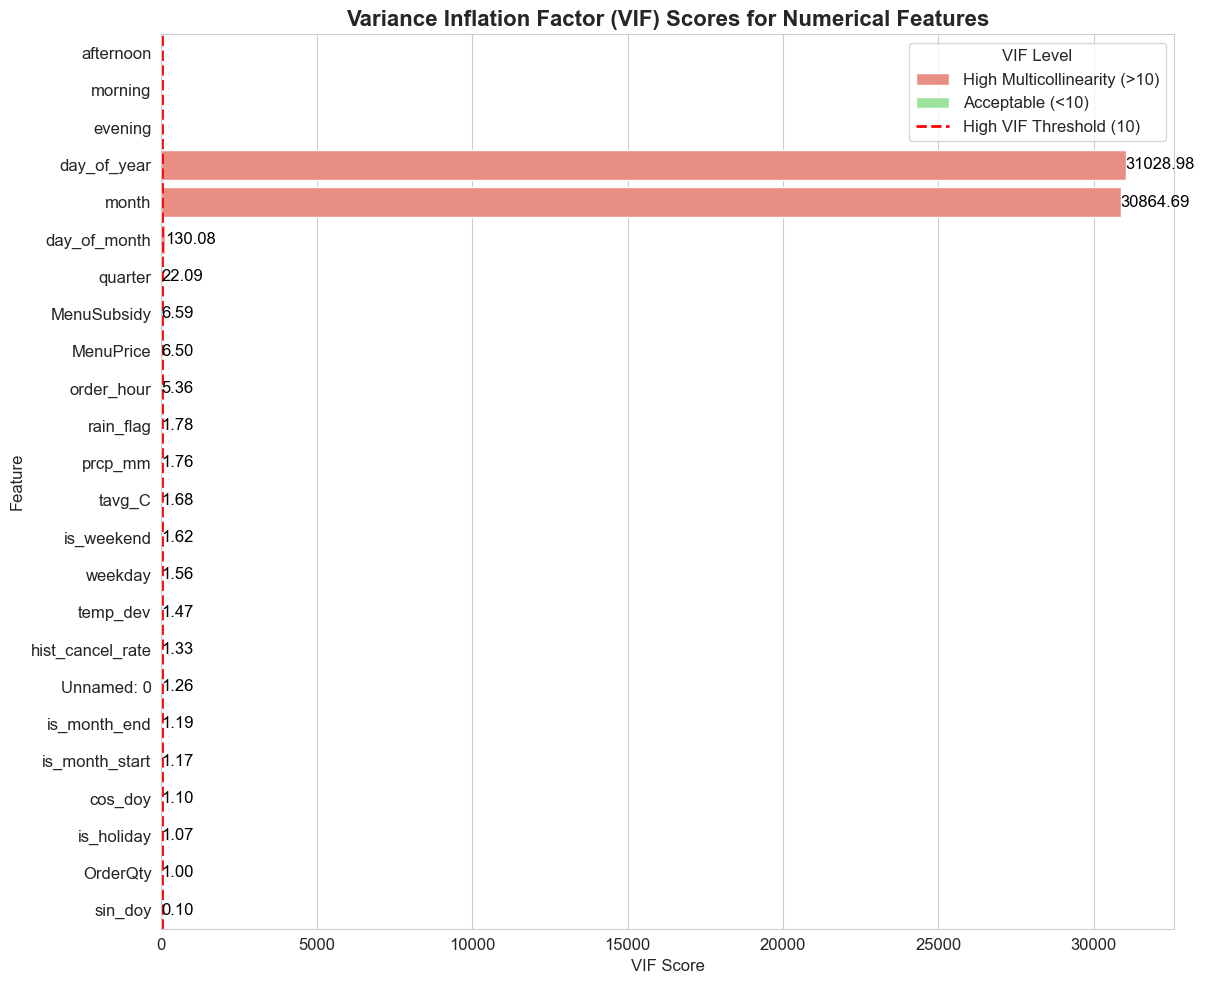


VIF visualization script finished.


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# =============================================================================
# --- Configuration ---
# =============================================================================
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 100

# =============================================================================
# --- Data Loading & VIF Calculation (from original script) ---
# =============================================================================
print("Loading data and calculating VIF scores...")
try:
    df_weather2 = pd.read_csv('/Users/shayan/Desktop/IDS2/Stattkueche/df_weather3.csv', parse_dates=['DateOfCancel', 'DateOfService'])
except FileNotFoundError:
    print("Creating a dummy dataframe for demonstration.")
    df_weather2 = pd.DataFrame({
        'OrderQty': np.random.randint(50, 200, 1000),
        'MenuPrice': np.random.uniform(3.5, 5.5, 1000),
        'MenuSubsidy': np.random.uniform(0.5, 1.5, 1000),
        'tavg_C': np.random.uniform(5, 25, 1000),
        'prcp_mm': np.random.uniform(0, 10, 1000),
        'rain_flag': np.random.randint(0, 2, 1000),
        'temp_dev': np.random.uniform(-5, 5, 1000),
        'is_holiday': np.random.randint(0, 2, 1000),
        'is_weekend': np.random.randint(0, 2, 1000),
        'sin_doy': np.random.rand(1000),
        'cos_doy': np.random.rand(1000),
        'month': np.random.randint(1, 13, 1000),
        'day_of_month': np.random.randint(1, 29, 1000),
        'is_month_end': np.random.randint(0, 2, 1000),
        'is_month_start': np.random.randint(0, 2, 1000),
    })


num_cols = df_weather2.select_dtypes(include=[np.number]).columns.to_list()
drop_col = ['DateOfOrder', 'DateOfService','days_to_cancel','CanceledQty','OrderId', 'TransactionId','cancel_timing','BookingNr','DateOfCancel','net_qty']
vif_col_1 = [c for c in num_cols if c not in drop_col]

vif_dat_1 = df_weather2[vif_col_1].copy()
vif_dat_1.replace([np.inf,-np.inf],np.nan,inplace=True)
vif_dat_1 = vif_dat_1.dropna()

print("Calculating VIF scores. This may take a moment...")
vif_scores_1 = [variance_inflation_factor(vif_dat_1.values, i) for i in range(vif_dat_1.shape[1])]
vif_table_1 = (pd.DataFrame({'feature':vif_col_1,'VIF':vif_scores_1})
               .sort_values('VIF',ascending=False)
               .reset_index(drop=True))

print("VIF calculation complete.")


# =============================================================================
# --- Chart 4: VIF Score Visualization ---
# =============================================================================
print("\nGenerating Chart 4: VIF Score Visualization...")
plt.figure(figsize=(12, 10))

# Separate high VIF and low VIF features for better visualization
high_vif_thresh = 10
vif_table_1['VIF_Category'] = np.where(vif_table_1['VIF'] > high_vif_thresh, 'High Multicollinearity (>10)', 'Acceptable (<10)')

# Create the bar plot
barplot = sns.barplot(y='feature', x='VIF', data=vif_table_1, hue='VIF_Category',
                      palette={'High Multicollinearity (>10)': 'salmon', 'Acceptable (<10)': 'lightgreen'},
                      dodge=False)

# Add a vertical line at the threshold
plt.axvline(x=high_vif_thresh, color='red', linestyle='--', linewidth=2, label=f'High VIF Threshold ({high_vif_thresh})')

plt.title('Variance Inflation Factor (VIF) Scores for Numerical Features', fontsize=16, weight='bold')
plt.xlabel('VIF Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.legend(title='VIF Level')
plt.tight_layout()

# Add VIF values as text on the bars
for index, row in vif_table_1.iterrows():
    barplot.text(row.VIF + 0.2, index, f'{row.VIF:.2f}', color='black', ha="left", va='center')

plt.savefig('VIF_Scores_Visualization.png')
plt.show()

print("\nVIF visualization script finished.")


Loading data and preparing for Stage A model training...
Training Stage A pipeline to extract feature names and importances...

Generating Chart 5: Stage A Feature Importance...


/var/folders/_4/yzd4h3k95051tj7kpg425rk80000gn/T/ipykernel_78113/2983916630.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='rocket')


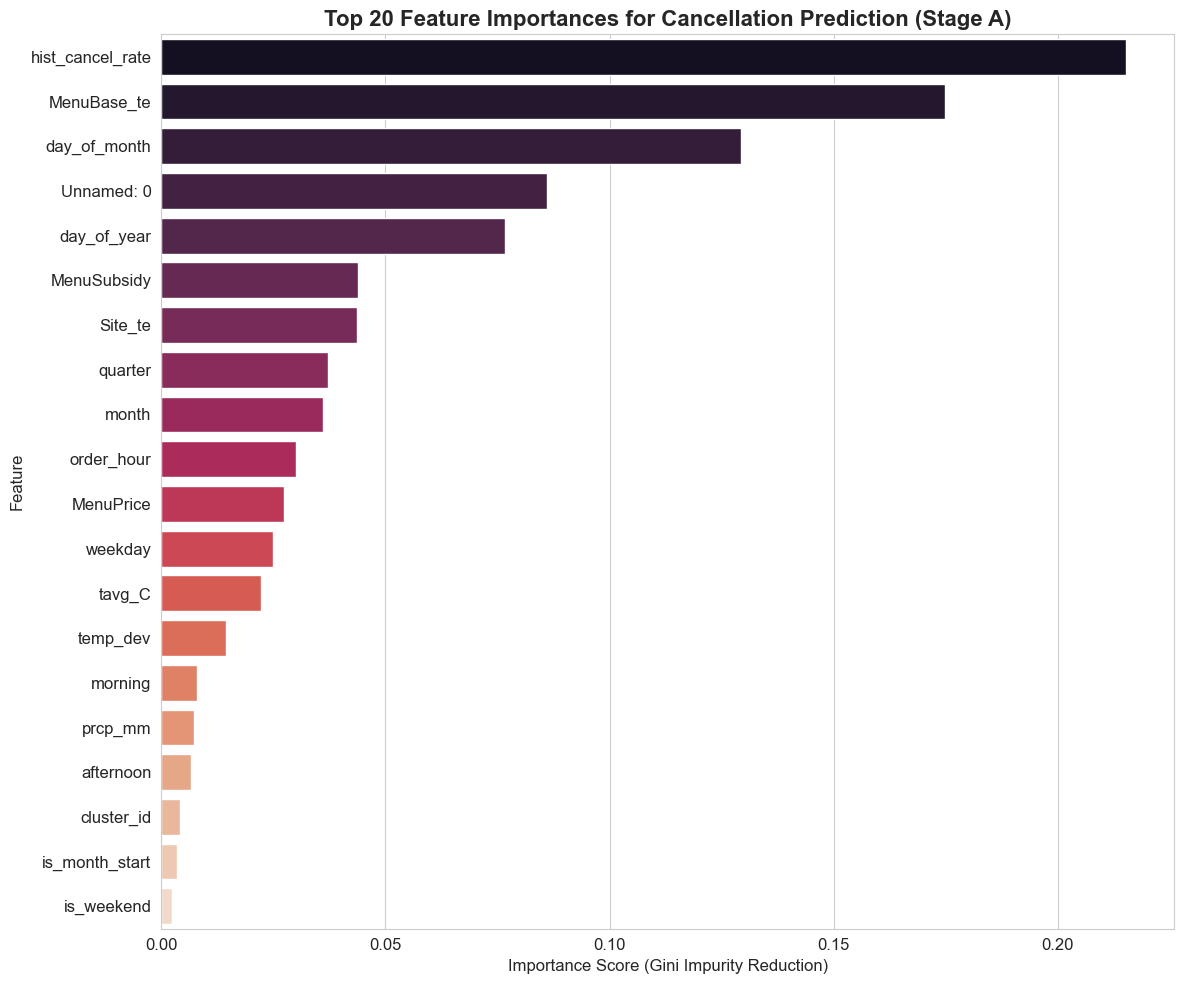


Feature importance visualization for Stage A finished.


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline

# =============================================================================
# --- Re-create necessary components from the original script ---
# =============================================================================
# NOTE: This script re-creates the pipeline from your code to train it on a
# sample of the data and extract the feature importances.

class InCVTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols, smoothing=1.0): self.cols, self.smoothing = cols, smoothing
    def fit(self, X, y):
        self.global_mean_ = y.mean()
        self.mapping_ = {}
        for c in self.cols:
            df = pd.DataFrame({c: X[c], 'target': y})
            agg = df.groupby(c)['target'].agg(['mean', 'count'])
            agg['enc'] = ((agg['count'] * agg['mean'] + self.smoothing * self.global_mean_) / (agg['count'] + self.smoothing))
            self.mapping_[c] = agg['enc']
        return self
    def transform(self, X):
        X_copy = X.copy()
        for c in self.cols:
            X_copy[c + '_te'] = X_copy[c].map(self.mapping_.get(c)).fillna(self.global_mean_)
        return X_copy

class HistCancelRateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, group_keys=('Site','MenuBase'), value_col='net_qty', out_col='hist_cancel_rate'):
        self.group_keys, self.value_col, self.out_col = group_keys, value_col, out_col
    def fit(self, X, y=None):
        self.hist_ = X.groupby(list(self.group_keys))[self.value_col].mean()
        self.default_ = self.hist_.median()
        return self
    def transform(self, X):
        tuples = [tuple(r) for r in X[list(self.group_keys)].values]
        X_copy = X.copy()
        X_copy[self.out_col] = [self.hist_.get(t, self.default_) for t in tuples]
        return X_copy

class ClusterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, profile_feats, group_keys=('Site','MenuBase'), n_clusters=5, out_col='cluster_id'):
        self.profile_feats, self.group_keys, self.n_clusters, self.out_col = profile_feats, group_keys, n_clusters, out_col
    def fit(self, X, y=None):
        prof = X.groupby(list(self.group_keys))[self.profile_feats].mean().reset_index()
        prof[self.profile_feats] = prof[self.profile_feats].fillna(prof[self.profile_feats].median())
        self.scaler_ = StandardScaler().fit(prof[self.profile_feats])
        scaled = self.scaler_.transform(prof[self.profile_feats])
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=10).fit(scaled)
        self.cluster_map_ = dict(zip([tuple(r) for r in prof[list(self.group_keys)].values], self.kmeans_.labels_))
        self.default_ = int(np.median(self.kmeans_.labels_))
        return self
    def transform(self, X):
        X_copy = X.copy()
        tuples = [tuple(r) for r in X[list(self.group_keys)].values]
        X_copy[self.out_col] = [self.cluster_map_.get(t, self.default_) for t in tuples]
        return X_copy

class MissingFlagImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='median'): self.strategy = strategy
    def fit(self, X, y=None):
        self.num_cols = X.select_dtypes(include=[np.number]).columns
        self.imputer_ = SimpleImputer(strategy=self.strategy).fit(X[self.num_cols].replace([np.inf,-np.inf], np.nan))
        return self
    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.num_cols] = X_copy[self.num_cols].replace([np.inf,-np.inf], np.nan)
        for c in self.num_cols: X_copy[c + '_missing'] = X_copy[c].isna().astype(int)
        X_copy[self.num_cols] = self.imputer_.transform(X_copy[self.num_cols])
        return X_copy

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, cols_to_drop): self.cols_to_drop = cols_to_drop
    def fit(self, X, y=None): return self
    def transform(self, X): return X.drop(columns=self.cols_to_drop, errors='ignore')

# --- Data Loading and Preparation ---
print("Loading data and preparing for Stage A model training...")
try:
    df_weather2 = pd.read_csv('/Users/shayan/Desktop/IDS2/Stattkueche/df_weather3.csv', parse_dates=['DateOfCancel', 'DateOfService'])
except FileNotFoundError:
    df_weather2 = pd.DataFrame({ # Dummy data
        'DateOfService': pd.to_datetime(pd.date_range(start='2022-01-01', periods=1000, freq='D')),
        'Site': np.random.choice(['siteMS', 'LP', 'BK'], 1000), 'MenuBase': np.random.choice([f'Menu_{i}' for i in range(5)], 1000),
        'CanceledQty': np.random.randint(0, 5, 1000), 'net_qty': np.random.randint(50, 150, 1000),
        'rain_flag': np.random.randint(0,2,1000), 'temp_dev': np.random.randn(1000), 'sin_doy': np.random.rand(1000),
        'cos_doy': np.random.rand(1000), 'month': np.random.randint(1,13,1000), 'day_of_month': np.random.randint(1,29,1000),
        'is_month_end': np.random.randint(0,2,1000), 'is_month_start': np.random.randint(0,2,1000), 'tavg_C': np.random.rand(1000)*20,
        'prcp_mm': np.random.rand(1000)*10, 'MenuName': ['A']*1000, 'MenuNorm': ['A']*1000, 'MenuCode': ['A']*1000, 'days_to_cancel': [1]*1000
    })

df_A = df_weather2.copy()
y_A = (df_A['CanceledQty'] > 0).astype(int)
X_A = df_A.drop(columns=['CanceledQty', 'cancel_timing', 'DateOfOrder', 'DateOfService', 'DateOfCancel', 'OrderId', 'TransactionId', 'BookingNr', 'hist_cancel_rate', 'GroupName', 'SchoolID'])
X_A_sample = X_A.sample(frac=0.25, random_state=42)
y_A_sample = y_A.loc[X_A_sample.index]

drop_cols_A = ['Site','MenuBase','MenuName','GroupName','MenuNorm','MenuCode','net_qty','days_to_cancel']
pipeline_A = ImbPipeline([
    ('te', InCVTargetEncoder(cols=['Site','MenuBase'], smoothing=0.3)),
    ('hist', HistCancelRateTransformer()),
    ('cluster', ClusterTransformer(profile_feats=['hist_cancel_rate','rain_flag','temp_dev','sin_doy', 'cos_doy', 'month', 'day_of_month', 'is_month_end', 'is_month_start','tavg_C', 'prcp_mm'], n_clusters=5)),
    ('drop', ColumnDropper(drop_cols_A)),
    ('impute', MissingFlagImputer()),
    ('clf', RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=8, min_samples_split=5, min_samples_leaf=1, max_features='sqrt', class_weight='balanced_subsample', random_state=24, n_jobs=-1)),
])

print("Training Stage A pipeline to extract feature names and importances...")
pipeline_A.fit(X_A_sample, y_A_sample)

# --- Extract Feature Names and Importances ---
# Get feature names after all transformations
temp_pipeline = ImbPipeline(pipeline_A.steps[:-1]) # All steps except the classifier
X_transformed = temp_pipeline.fit_transform(X_A_sample, y_A_sample)
feature_names = X_transformed.columns

importances = pipeline_A.named_steps['clf'].feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)

# =============================================================================
# --- Chart 5: Stage A Feature Importance ---
# =============================================================================
print("\nGenerating Chart 5: Stage A Feature Importance...")
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='rocket')
plt.title('Top 20 Feature Importances for Cancellation Prediction (Stage A)', fontsize=16, weight='bold')
plt.xlabel('Importance Score (Gini Impurity Reduction)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('Feature_Importance_Stage_A.png')
plt.show()

print("\nFeature importance visualization for Stage A finished.")


------------------------------------------------------------
Generating Final Performance Analysis...
------------------------------------------------------------

[1/5] Comparing all tuned models...


/var/folders/_4/yzd4h3k95051tj7kpg425rk80000gn/T/ipykernel_78113/2119767573.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='ROC AUC Score', y='Model', data=score_df, palette='viridis', width=0.6)


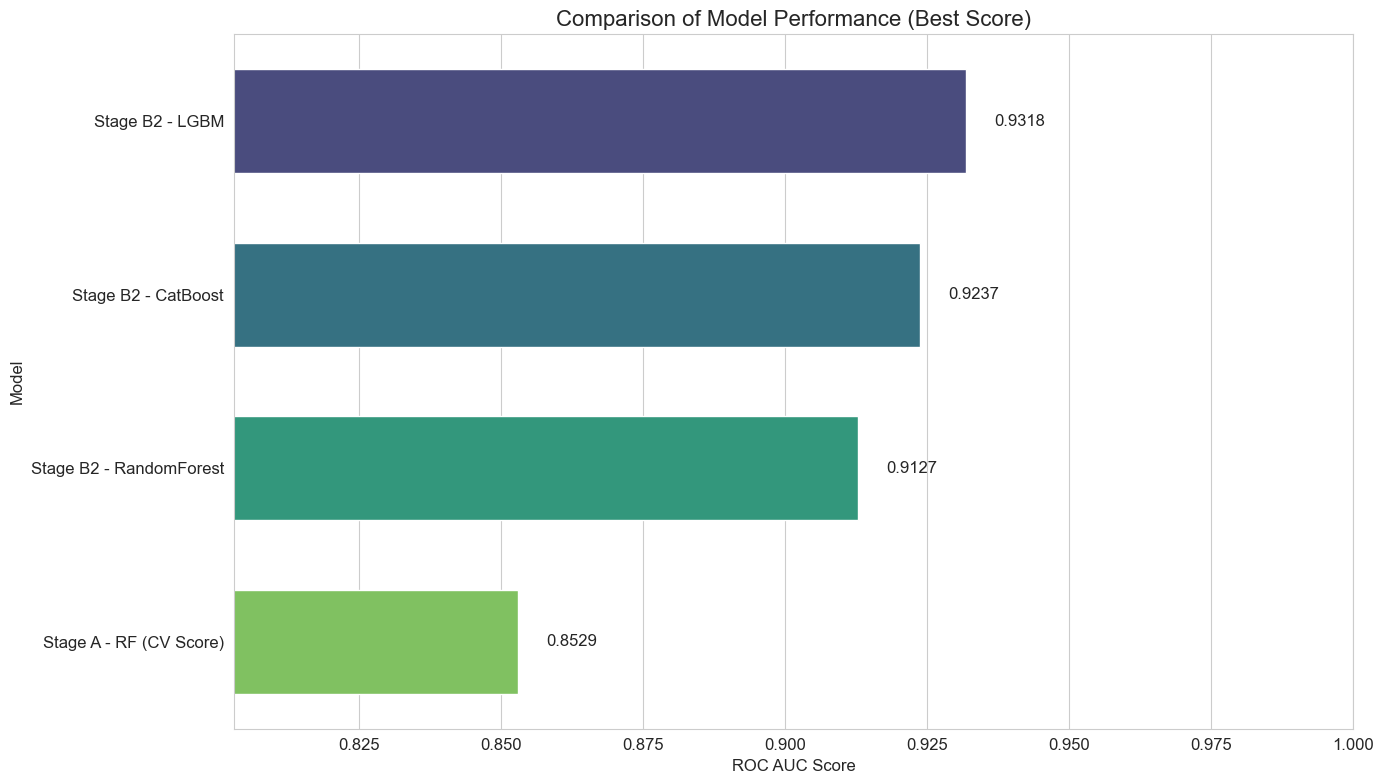


------------------------------------------------------------
Deep Dive Analysis for the Best Stage B2 Model: **LGBM**
------------------------------------------------------------

[2/5] Generating Classification Report and Confusion Matrices...


ValueError: cross_val_predict only works for partitions

In [23]:
# =============================================================================
# 9. FINAL PERFORMANCE VISUALIZATION & ANALYSIS 📊
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_predict
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)

# Setup plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

print("---" * 20)
print("Generating Final Performance Analysis...")
print("---" * 20)


# --- 1. Overall Model Performance Comparison ---
print("\n[1/5] Comparing all tuned models...")

# This logic correctly uses the 'scores' variable from Stage 4
# and the final search objects from Stages 6, 7, and 8.
model_scores = {
    'Stage A - RF (CV Score)': np.mean(scores),
    'Stage B2 - RandomForest': search_rf.best_score_,
    'Stage B2 - LGBM': search_lgbm_b2.best_score_,
    'Stage B2 - CatBoost': search_cat.best_score_,
}
score_df = pd.DataFrame(list(model_scores.items()), columns=['Model', 'ROC AUC Score']).sort_values('ROC AUC Score', ascending=False)

plt.figure()
ax = sns.barplot(x='ROC AUC Score', y='Model', data=score_df, palette='viridis', width=0.6)
ax.set_title('Comparison of Model Performance (Best Score)', fontsize=16)
ax.set_xlim(left=max(0, score_df['ROC AUC Score'].min() - 0.05 if score_df['ROC AUC Score'].min() > 0 else 0), right=1.0)
for p in ax.patches:
    ax.annotate(f'{p.get_width():.4f}', (p.get_width() + 0.005, p.get_y() + p.get_height() / 2), ha='left', va='center')
plt.tight_layout()
plt.show()


# --- 2. Deep Dive into the Best Stage B2 Model ---
# Programmatically find the best model from the Stage B2 searches
stage_b2_searches = {
    "RandomForest": search_rf,
    "LGBM": search_lgbm_b2,
    "CatBoost": search_cat,
}
best_model_name = max(stage_b2_searches, key=lambda k: stage_b2_searches[k].best_score_)
best_model_pipe = stage_b2_searches[best_model_name].best_estimator_

print("\n" + "---" * 20)
print(f"Deep Dive Analysis for the Best Stage B2 Model: **{best_model_name}**")
print("---" * 20)


# --- 3. Classification Report & Confusion Matrices ---
print("\n[2/5] Generating Classification Report and Confusion Matrices...")

# Get out-of-sample predictions to evaluate the model fairly
# This uses the same data sample (X_B2, y_B2) and CV splits (tscv_fast) that the model was trained on
y_pred = cross_val_predict(best_model_pipe, X_B2, y_B2, cv=tscv_fast)

# Print Classification Report (Precision, Recall, F1-Score table)
print("\nClassification Report:")
print(classification_report(y_B2, y_pred, target_names=le.classes_, digits=3))


# Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle(f'Confusion Matrices for {best_model_name} Model', fontsize=18)
# Plot Raw Counts
ConfusionMatrixDisplay.from_predictions(y_B2, y_pred, display_labels=le.classes_, cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix (Raw Counts)')
axes[0].tick_params(axis='x', rotation=45)
# Plot Normalized (Percentages)
ConfusionMatrixDisplay.from_predictions(y_B2, y_pred, display_labels=le.classes_, cmap='Oranges', normalize='true', ax=axes[1])
axes[1].set_title('Normalized Confusion Matrix (%)')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# --- 4. Feature Importance Plot ---
print("\n[3/5] Generating Feature Importance plot...")

# Get final feature names after all pipeline transformations
pipeline_pre_clf = ImbPipeline(best_model_pipe.steps[:-1])
X_transformed = pipeline_pre_clf.fit_transform(X_B2, y_B2)
final_feature_names = X_transformed.columns.tolist()

# Get importances from the trained classifier step
importances = best_model_pipe.named_steps['clf'].feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': final_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(14, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='mako')
plt.title(f'Top 20 Feature Importances from {best_model_name} Model', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


# --- 5. ROC Curves (One-vs-Rest) ---
print("\n[4/5] Generating ROC Curves...")

# Binarize the output and get prediction probabilities
y_B2_binarized = label_binarize(y_B2, classes=np.unique(y_B2))
n_classes = y_B2_binarized.shape[1]
y_proba = cross_val_predict(best_model_pipe, X_B2, y_B2, cv=tscv_fast, method='predict_proba')

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_B2_binarized[:, i], y_proba[:, i])
    roc_auc[i] = roc_auc_score(y_B2_binarized[:, i], y_proba[:, i])

plt.figure(figsize=(12, 8))
colors = plt.cm.get_cmap('tab10', n_classes)
for i, color in zip(range(n_classes), colors.colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC for {le.inverse_transform([i])[0]} (area = {roc_auc[i]:0.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Multi-class ROC Curves for {best_model_name} Model', fontsize=16)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print("\n[5/5] Analysis complete.")
print("---" * 20)